In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
net = nn.Sequential(
  nn.LazyLinear(256),
  nn.ReLU(),
  nn.LazyLinear(10)
)

X = torch.rand(2, 20)
net(X).shape

torch.Size([2, 10])

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.out = nn.LazyLinear(10)

    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

In [5]:
net = MLP()
net(X).shape

torch.Size([2, 10])

In [6]:
class MySequential(nn.Module):
  def __init__(self, *args):
    super().__init__()
    
    for idx, module in enumerate(args):
      self.add_module(str(idx), module)
      
  def forward(self, X):
    for module in self.children():
      X = module(X)
    return X

In [7]:
net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net(X).shape

torch.Size([2, 10])

In [9]:
class FixedHiddenMLP(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.rand_weight = torch.rand((20, 20))
    self.linear = nn.LazyLinear(20)
  
  def forward(self, X):
    
    X = self.linear(X)
    X = F.relu(X @ self.rand_weight + 1)
    X = self.linear(X)
    
    while X.abs().sum() > 1:
      X /= 2
    return X.sum()

In [10]:
net = FixedHiddenMLP()
net(X)

tensor(-0.1896, grad_fn=<SumBackward0>)

In [11]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(),
                                 nn.LazyLinear(32), nn.ReLU())
        self.linear = nn.LazyLinear(16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(X)

tensor(-0.0200, grad_fn=<SumBackward0>)

### Exercises

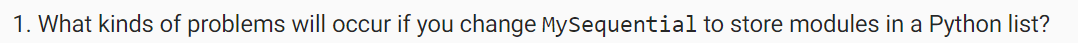

In [14]:
class MySequential(nn.Module):
  def __init__(self, *args):
    super().__init__()
    self.modules = []
    
    for idx, module in enumerate(args):
      self.modules.append((str(idx), module))
      
  def forward(self, X):
    for name, module in self.modules:
      X = module(X)
    return X

1. Parameters Will Not Be Discovered

PyTorch’s `nn.Module` relies on internal tracking to know which parameters ( and ) belong to it. When you use `self.add_module()` or assign a module directly to an attribute (like `self.layer1 = nn.Linear(...)`), PyTorch automatically registers that module's parameters.

* **The Problem:** A standard Python list is "invisible" to PyTorch.
* **The Result:** If you call `model.parameters()`, the list will be empty.
* **Consequence for Training:** When you pass `model.parameters()` to an optimizer (like `SGD` or `Adam`), the optimizer will have nothing to update. Your model's weights will remain at their initial random values forever.

2. Device and Type Transfers Will Fail

PyTorch modules provide convenient methods like `.to('cuda')` to move the model to a GPU or `.half()` to change precision. These methods work by recursively iterating through all registered sub-modules.

* **The Problem:** Since the modules in a Python list are not registered, these recursive calls will skip them.
* **The Result:** If you call `model.to('cuda')`, the "outer" container might technically move, but all the actual layers inside your list will remain on the **CPU**.
* **Consequence:** You will get a `RuntimeError` during the forward pass because PyTorch cannot perform operations where the data is on the GPU but the weights are on the CPU.

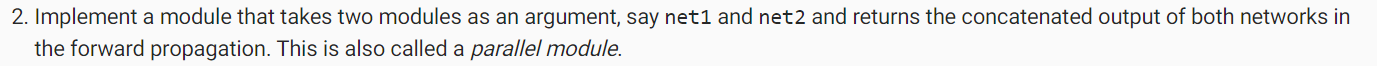

In [35]:
class ParallelModule(nn.Module):
  def __init__(self, *args):
    super().__init__()
    
    for idx, module in enumerate(args):
      self.add_module(str(idx), module)
      
  def forward(self, X):
    outputs = []
    
    for module in self.children():
      outputs.append(module(X))
    
    return torch.cat(outputs, dim=1)

In [36]:
net1 = nn.LazyLinear(20)
net2 = nn.LazyLinear(15)

parallel = ParallelModule(
  net1,
  net2
)

X = torch.randn(20, 20)
parallel(X).shape

torch.Size([20, 35])

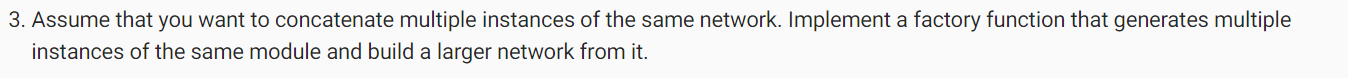

In [56]:
def factory(Module, n, *args, **kwargs):
  return nn.ModuleList([Module(*args, **kwargs) for _ in range(n)])

In [57]:
factory(Module=nn.LazyLinear, n=5, out_features=10)

ModuleList(
  (0-4): 5 x LazyLinear(in_features=0, out_features=10, bias=True)
)